## Full Spectrum2Combined
### from New Data/Spectrum blocked (widest)/A0036 and New Data/Spectrum (widest)/A0035

In [21]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [22]:
# Calibration numbers come from multiple calibrations with proper error analysis and weighted averaging
# Calulations can be found in "Multiple Plot Calibration"
CalM = -5.169066740202884
#CalM_err = 1.8472146461547026e-06
CalM_err = 0.36697628437204854

# define functions
def LinearFunc(t, a, b):
    return a * t + b

def ChiSqrd(Data, Fit, Error):
    return sum( (Data - Fit)**2 ) / (Error**2)

def RdChiSqrd(Data, Fit, Error, NumPrams):
    return sum( (Data - Fit)**2 ) / (Error**2 * (np.size(Data) - NumPrams - 2))

def Cali(t, t0, DriveSlope):
    return (10 * DriveSlope * CalM * (t - t0))

def Cali_Err(t, t_err, t0, t0_err, DriveSlope, DriveSlope_err):
    return np.sqrt( (10 * DriveSlope_err * CalM * (t - t0))**2 +
                    (10 * DriveSlope * CalM_err * (t - t0))**2 +
                    (10 * DriveSlope * CalM * t_err)**2 +
                    (10 * DriveSlope * CalM * t0_err)**2 )

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, (len(params)-2), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( (-1/2) * ((x - ctr)/wid)**2)
    return y + x * params[12] + params[13]

50.8061249517341
0.02463351261572862


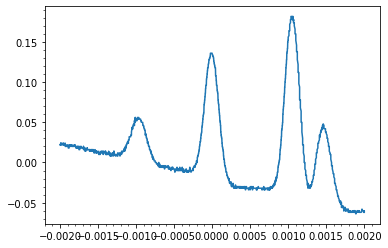

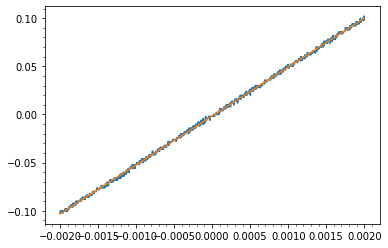

In [23]:
data =  pd.read_csv("New Data/Spectrum2 blocked/A0034CH1.CSV")
x = pd.DataFrame(data, columns= ['col 1'])
y = pd.DataFrame(data, columns= ['col 2'])
x = np.resize(x,(4000,1))
y = np.resize(y,(4000,1))

rampdata =  pd.read_csv("New Data/Spectrum2 blocked/A0034CH2.CSV")
rampx = pd.DataFrame(rampdata, columns= ['col 1'])
rampy = pd.DataFrame(rampdata, columns= ['col 2'])
rampx = np.resize(rampx,(4000,1))
rampy = np.resize(rampy,(4000,1))

#plt.plot(rampx,rampy)

t_start = -0.002
t_end = 0.002

j = 0
for i in x:
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    j += 1

x = x[t1:t2,0]
y = y[t1:t2,0]
rampx = rampx[t1:t2,0]
rampy = rampy[t1:t2,0]

RampGuess = [36, 0.2]
RampParam, RampParam_cov = curve_fit(LinearFunc, rampx, rampy, RampGuess, maxfev=150000)

RampSlope = RampParam[0]
RampSlope_err = RampParam_cov[0,0]
print(RampSlope)
print(np.sqrt(RampParam_cov[0,0]))

plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.plot(rampx,LinearFunc(rampx,*RampParam))
plt.minorticks_on()
plt.show()

Y-error = (+/-) 0.0011721875806530925
[-1.84678809e+01 -1.38267820e-02]


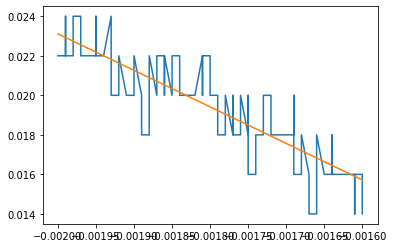

In [24]:
# Finds Error in the voltage

# Find flat '0' segments
# Here I'm taking from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == -0.002:
        t1 = j
    if i == -0.0016:
        t2 = j
    j += 1
    
x_back = x[t1:t2]
y_back = y[t1:t2]

Back_guess = [-18,-.014]

Back_popt, Back_pcov = optimize.curve_fit(LinearFunc, x_back, y_back, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_back - LinearFunc(x_back, *Back_popt))**2 ) / (np.size(x_back) - 2) )

print("Y-error = (+/-) " + str(V_error))

print(Back_popt)

plt.plot(x_back,y_back)
plt.plot(x_back, LinearFunc(x_back, *Back_popt))
plt.show()

V_errorA = V_error * np.linspace(1,1,np.size(x))
    

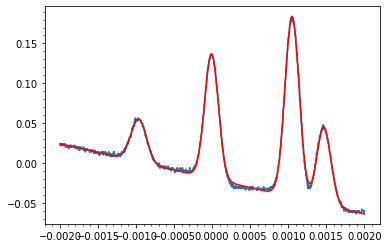

Reduced Chi Squared = 4.262792142740333


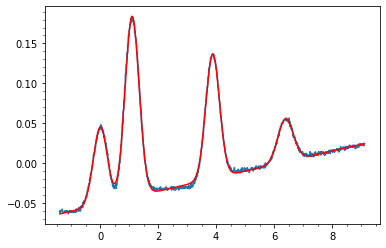

[-0.          1.09858207  3.88023459  6.39650636]
[0.00134133 0.07800033 0.27547829 0.45412247]

[-1.34133106e-03  1.02058175e+00  3.60475630e+00  5.94238389e+00]
[1.34133106e-03 1.17658240e+00 4.15571288e+00 6.85062882e+00]


[-0.56634773  0.57280065 -0.55730562  0.62641355]
[0.04028145 0.04067869 0.03959105 0.04469084]

[-0.60662918  0.53212196 -0.59689666  0.58172271]
[-0.52606628  0.61347933 -0.51771457  0.67110439]


In [25]:
# Fit curve, apply Calibration
guess = [-0.001, 0.05000, 0.00020, -0.0003, 0.15000, 0.00020, 0.001, 0.21000, 0.00020, 0.0015, 0.05000, 0.00020, -18, -.0138]
# position, amplitude, width

popt, pcov = optimize.curve_fit(func, x, y, p0=guess, sigma= V_errorA, maxfev=200000)
fit = func(x, *popt)

#Rb87F1, Rb85F2, Rb85F3, Rb87F2
PosArray = np.array([popt[9], popt[6], popt[3], popt[0]])
PosErrArray = np.array([np.sqrt(pcov[9,9]), np.sqrt(pcov[6,6]), np.sqrt(pcov[3,3]), np.sqrt(pcov[0,0])])
WidthArray = np.array([popt[11], popt[8], popt[5], popt[2]])
WidthErrArray = np.array([np.sqrt(pcov[11,11]), np.sqrt(pcov[8,8]), np.sqrt(pcov[5,5]), np.sqrt(pcov[2,2])])

FWHMArray = 2.35482 * WidthArray
FWHMErrArray = 2.35482 * WidthErrArray

RCS = RdChiSqrd(y, func(x, *popt), V_error, 12)

plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()
print("Reduced Chi Squared = " + str(RCS))

#print(PosArray)

ZeroPos = popt[9]
ZeroPos_err = np.sqrt(pcov[9,9])

#Cali(t, t0, DriveSlope)
#Cali_Err(t, t_err, t0, t0_err, DriveSlope, DriveSlope_err)

# Calibration on all points
Calx = Cali(x, PosArray[0], RampSlope)

plt.plot(Calx, y)
plt.plot(Calx, func(x, *popt), 'r-')
plt.minorticks_on()
plt.show()

CalPosArray = Cali(PosArray, PosArray[0], RampSlope)
CalPosErrArray = Cali_Err(PosArray, PosErrArray, PosArray[0], PosErrArray[0], RampSlope, RampSlope_err)

CalWidthArray = (-1)*Cali(WidthArray, 0, RampSlope)



CalWidthErrArray1 = Cali_Err(WidthArray, WidthErrArray, 0, 0, RampSlope, RampSlope_err)
#CalWidthErrArray2 = Cali_Err(WidthArray, WidthErrArray, PosArray, PosErrArray, RampSlope, RampSlope_err)
#CalWidthErrArray3 = Cali_Err(WidthArray, WidthErrArray, PosArray[0], PosErrArray[0], RampSlope, RampSlope_err)

CalFWHMArray = 2.35482 * CalWidthArray
CalFWHMErrArray = 2.35482 * CalWidthErrArray1

print(CalPosArray)
print(CalPosErrArray)
print("")
print(CalPosArray-CalPosErrArray)
print(CalPosArray+CalPosErrArray)
print("")
print("")
print(CalFWHMArray)
print(CalFWHMErrArray)
print("")
print(CalFWHMArray-CalFWHMErrArray)
print(CalFWHMArray+CalFWHMErrArray)

## Unblocked

50.86765721670068
0.02462719475122793


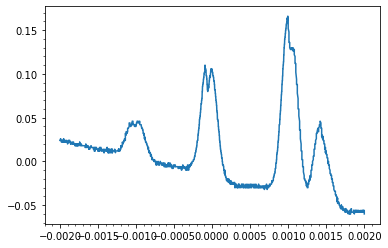

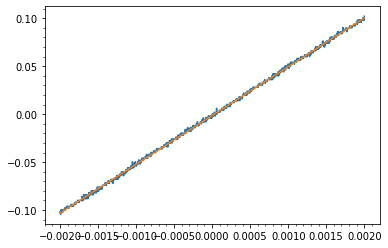

In [26]:
Udata =  pd.read_csv("New Data/Spectrum2/A0033CH1.CSV")
Ux = pd.DataFrame(Udata, columns= ['col 1'])
Uy = pd.DataFrame(Udata, columns= ['col 2'])
Ux = np.resize(Ux,(4000,1))
Uy = np.resize(Uy,(4000,1))

Urampdata =  pd.read_csv("New Data/Spectrum2/A0033CH2.CSV")
Urampx = pd.DataFrame(Urampdata, columns= ['col 1'])
Urampy = pd.DataFrame(Urampdata, columns= ['col 2'])
Urampx = np.resize(Urampx,(4000,1))
Urampy = np.resize(Urampy,(4000,1))

#plt.plot(Urampx,Urampy)

t_start = -0.002
t_end = 0.002

j = 0
for i in Ux:
    if i == t_start:
        Ut1 = j
    if i == t_end:
        Ut2 = j
    j += 1

Ux = Ux[Ut1:Ut2,0]
Uy = Uy[Ut1:Ut2,0]
Urampx = Urampx[Ut1:Ut2,0]
Urampy = Urampy[Ut1:Ut2,0]

URampGuess = [36, 0.2]
URampParam, URampParam_cov = curve_fit(LinearFunc, Urampx, Urampy, URampGuess, maxfev=150000)

URampSlope = URampParam[0]
print(URampSlope)
print(np.sqrt(URampParam_cov[0,0]))

plt.plot(Ux,Uy)
plt.minorticks_on()
plt.show()
plt.plot(Urampx,Urampy)
plt.plot(Urampx,LinearFunc(Urampx,*URampParam))
plt.minorticks_on()
plt.show()

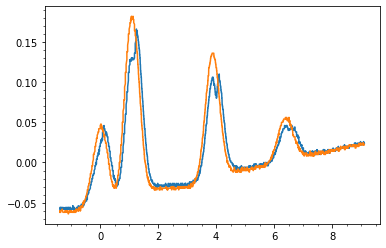

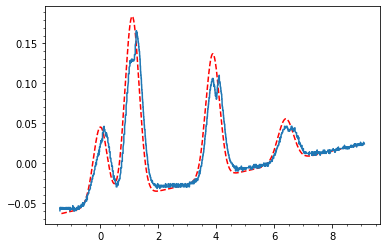

In [27]:
UCalx = Cali(Ux, ZeroPos, RampSlope)
UyFlat = Uy - LinearFunc(UCalx, popt[12], popt[13])

plt.plot(UCalx, Uy)
plt.plot(Calx, y)
plt.minorticks_on()
plt.show()

plt.plot(UCalx, func(Ux, *popt), 'r--')
plt.plot(UCalx, Uy)
plt.minorticks_on()
plt.show()

#plt.plot(Calx, yFlat)
#plt.plot(UCalx, UyFlat)
#plt.minorticks_on()
#plt.show()